In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, LocallyConnected2D, MaxPooling2D, GlobalMaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Conv1D, LocallyConnected1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, CuDNNLSTM, CuDNNGRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
from keras.utils.generic_utils import Progbar
from keras.layers.merge import _Merge
import keras.losses

from functools import partial

from collections import defaultdict

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

from sequence_logo_helper import plot_dna_logo

import pandas as pd

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()

class EpochVariableCallback(Callback) :
    
    def __init__(self, my_variable, my_func) :
        self.my_variable = my_variable       
        self.my_func = my_func
        
    def on_epoch_begin(self, epoch, logs={}) :
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))

from scipy.stats import pearsonr, spearmanr


Using TensorFlow backend.


In [2]:
#Define tissue-/cell- types

cell_types = np.array(['apadb_count_kidney',
       'apadb_count_pancreas',
       'apadb_count_monocytes',
       'apadb_count_all',
       'apadb_count_pdac',
       'apadb_count_prcc',
       'apadb_count_full_blood',
       'apadb_count_hlf',
       'apadb_count_pooled',
       'leslie_count_hek293',
       'leslie_count_mcf10a_hras2',
       'leslie_count_mcf10a1',
       'leslie_count_mcf10a2',
       'leslie_count_mcf10a_hras1',
       'leslie_count_bcells1',
       'leslie_count_mcf7',
       'leslie_count_bcells2',
       'leslie_count_ovary',
       'leslie_count_breast',
       'leslie_count_brain',
       'leslie_count_skmuscle',
       'leslie_count_blcl',
       'leslie_count_hES',
       'leslie_count_testis',
       'leslie_count_hela',
       'leslie_count_ntera',
       'leslie_count_pooled',
       'leslie_count_apadb_region_hek293',
       'leslie_count_apadb_region_mcf10a_hras2',
       'leslie_count_apadb_region_mcf10a1',
       'leslie_count_apadb_region_mcf10a2',
       'leslie_count_apadb_region_mcf10a_hras1',
       'leslie_count_apadb_region_bcells1',
       'leslie_count_apadb_region_mcf7',
       'leslie_count_apadb_region_bcells2',
       'leslie_count_apadb_region_ovary',
       'leslie_count_apadb_region_breast',
       'leslie_count_apadb_region_brain',
       'leslie_count_apadb_region_skmuscle',
       'leslie_count_apadb_region_blcl',
       'leslie_count_apadb_region_hES',
       'leslie_count_apadb_region_testis',
       'leslie_count_apadb_region_hela',
       'leslie_count_apadb_region_ntera',
       'leslie_count_apadb_region_pooled',
       'derti_count_brain',
       'derti_count_kidney',
       'derti_count_liver',
       'derti_count_maqc-brain1',
       'derti_count_maqc-brain2',
       'derti_count_maqc-UHR1',
       'derti_count_maqc-UHR2',
       'derti_count_muscle',
       'derti_count_testis',
       'derti_count_pooled',
], dtype=np.object)

cell_type_dict = {
    cell_type : cell_type_i for cell_type_i, cell_type in enumerate(cell_types)
}


In [3]:
#Load data features

save_dict = np.load("leslie_derti_apadb_features_pas_2_utr3_all_cuts.npz")

#Include cell types

included_cell_types = [
    'leslie_count_hek293',
    'leslie_count_brain'
]

x, m, l, c, y, s = save_dict['x'], save_dict['m'], save_dict['l'], save_dict['c'], save_dict['y'], save_dict['s']

#Add extra singleton dim to x
x = np.expand_dims(x, axis=2)

#Shuffle c and y dimensions
c = np.transpose(c, (0, 2, 1))
y = np.transpose(y, (0, 2, 1))

#Slice celltypes

included_cell_type_ixs = [cell_type_dict[cell_type] for cell_type in included_cell_types]

cell_types = cell_types[included_cell_type_ixs]
c = c[:, included_cell_type_ixs, :]
y = y[:, included_cell_type_ixs, :]
s = s[:, included_cell_type_ixs]

cell_type_dict = {
    cell_type : cell_type_i for cell_type_i, cell_type in enumerate(cell_types)
}

print("x.shape = " + str(x.shape))
print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("c.shape = " + str(c.shape))
print("y.shape = " + str(y.shape))
print("s.shape = " + str(s.shape))


x.shape = (6440, 10, 1, 205, 4)
m.shape = (6440, 10)
l.shape = (6440, 10)
c.shape = (6440, 2, 10)
y.shape = (6440, 2, 10)
s.shape = (6440, 2)


In [4]:
#Collapse/omit PASes that are to close in spatial distance

collapse_if_within = 50.
omit_if_within = 100.

for i in range(x.shape[0]) :
    
    curr_pas = 0
    next_pas = 1
    
    while next_pas < x.shape[1] :
        
        if m[i, next_pas] <= 0. :
            break
        
        if l[i, next_pas] <= collapse_if_within :
            
            x[i, next_pas:-1, ...] = x[i, next_pas+1:, ...]
            
            c[i, :, curr_pas] += c[i, :, next_pas]
            c[i, :, next_pas:-1] = c[i, :, next_pas+1:]
            
            m[i, next_pas:-1] = m[i, next_pas+1:]
            
            temp_l = l[i, next_pas]
            l[i, next_pas:-1] = l[i, next_pas+1:]
            
            if m[i, next_pas] == 1. :
                l[i, next_pas] += temp_l
            
            next_pas -= 1
            
        elif l[i, next_pas] <= omit_if_within :
            
            x[i, next_pas:-1, ...] = x[i, next_pas+1:, ...]
            c[i, :, next_pas:-1] = c[i, :, next_pas+1:]
            m[i, next_pas:-1] = m[i, next_pas+1:]
            
            temp_l = l[i, next_pas]
            l[i, next_pas:-1] = l[i, next_pas+1:]
            
            if m[i, next_pas] == 1. :
                l[i, next_pas] += temp_l
            
            next_pas -= 1
            
        else :
            curr_pas += 1
        
        next_pas += 1


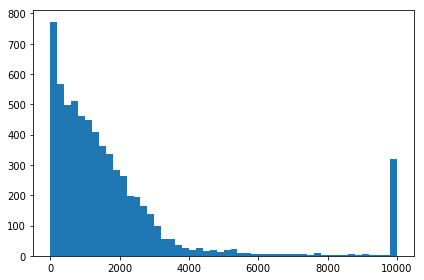

In [5]:

f = plt.figure(figsize=(6, 4))

plt.hist(np.minimum(np.max(l, axis=1), 10000.), bins=50)

plt.tight_layout()

plt.show()


In [6]:
#Re-filter on max_n_pas

max_n_pas = 10

min_total_count = 10

x = x[:, :max_n_pas, ...]
m = m[:, :max_n_pas]
l = l[:, :max_n_pas]
c = c[:, :, :max_n_pas]

total_c = np.sum(c, axis=-1)
total_m = np.sum(m, axis=1)
max_l = np.max(l, axis=1)

x = x[(np.all(total_c > min_total_count, axis=-1) & (total_m >= 2)) & (max_l < 10000.), ...]
m = m[(np.all(total_c > min_total_count, axis=-1) & (total_m >= 2)) & (max_l < 10000.), :]
l = l[(np.all(total_c > min_total_count, axis=-1) & (total_m >= 2)) & (max_l < 10000.), :]
c = c[(np.all(total_c > min_total_count, axis=-1) & (total_m >= 2)) & (max_l < 10000.), ...]

y = c / np.sum(c, axis=2, keepdims=True)
y[np.isnan(y)] = 0.

s = np.array(np.sum(c, axis=2) > 0, dtype=np.float)

print("x.shape = " + str(x.shape))
print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("c.shape = " + str(c.shape))
print("y.shape = " + str(y.shape))
print("s.shape = " + str(s.shape))


x.shape = (4715, 10, 1, 205, 4)
m.shape = (4715, 10)
l.shape = (4715, 10)
c.shape = (4715, 2, 10)
y.shape = (4715, 2, 10)
s.shape = (4715, 2)


In [7]:

cell_type_differences = [
    ['leslie_count_hek293', 'leslie_count_brain']
]

d = np.zeros((x.shape[0], s.shape[1], s.shape[1]))

for [cell_type_1, cell_type_2] in cell_type_differences :
    
    cell_type_1_ix = cell_type_dict[cell_type_1]
    cell_type_2_ix = cell_type_dict[cell_type_2]
    
    d[:, cell_type_1_ix, cell_type_2_ix] = 1.

print("x.shape = " + str(x.shape))
print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("c.shape = " + str(c.shape))
print("y.shape = " + str(y.shape))
print("s.shape = " + str(s.shape))
print("d.shape = " + str(d.shape))


x.shape = (4715, 10, 1, 205, 4)
m.shape = (4715, 10)
l.shape = (4715, 10)
c.shape = (4715, 2, 10)
y.shape = (4715, 2, 10)
s.shape = (4715, 2)
d.shape = (4715, 2, 2)


In [8]:
#Log-transform feature matrix l

l = np.log(np.cumsum(l, axis=1) * m + 1.)
l = np.maximum(l - 5., 0)


In [9]:
#Load APARENT Resnet

model_name = 'aparent_all_libs_resnet_no_clinvar_wt_ep_5'

save_dir = os.path.join(os.getcwd(), '')
model_path = os.path.join(save_dir, model_name + '.h5')

aparent = load_model(model_path)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [10]:
#Score all sequences with APARENT (use sum of cuts to capture OR-like logic)

isoform_start = 0
isoform_end = 185

a = np.zeros((x.shape[0], x.shape[1]))
for k in range(x.shape[1]) :
    
    print("Predicting for PAS #" + str(k) + "...")
    
    onehots = x[:, k, ...]
    
    fake_lib = np.zeros((onehots.shape[0], 13))
    fake_lib[:, 11] = 1.
    
    #Pad
    n_pad = 32 - onehots.shape[0] % 32 if onehots.shape[0] % 32 != 0 else 0

    fake_lib = np.concatenate([fake_lib, np.zeros((n_pad, 13))], axis=0)
    onehots = np.concatenate([onehots, np.zeros((n_pad, 1, 205, 4))], axis=0)
    
    _, pred_cuts = aparent.predict(x=[onehots, fake_lib], batch_size=32, verbose=1)
    
    if n_pad > 0 :
        pred_cuts = pred_cuts[:-n_pad, :]
    
    pred_iso = np.sum(pred_cuts[:, isoform_start:isoform_end], axis=1)
    pred_logit = np.log(pred_iso / (1. - pred_iso))
    
    pred_norm_score = (pred_logit - np.mean(pred_logit)) / np.std(pred_logit)
    
    a[:, k] = pred_norm_score[:]

a = a * m
a = np.clip(a, -5., 5.)


Predicting for PAS #0...
4736/4736 [==============================] - 23s 5ms/step
Predicting for PAS #1...
4736/4736 [==============================] - 21s 4ms/step
Predicting for PAS #2...
4736/4736 [==============================] - 21s 4ms/step
Predicting for PAS #3...
4736/4736 [==============================] - 21s 4ms/step
Predicting for PAS #4...
4736/4736 [==============================] - 22s 5ms/step
Predicting for PAS #5...
4736/4736 [==============================] - 21s 4ms/step
Predicting for PAS #6...
4736/4736 [==============================] - 21s 4ms/step
Predicting for PAS #7...
4736/4736 [==============================] - 21s 4ms/step
Predicting for PAS #8...
4736/4736 [==============================] - 21s 4ms/step
Predicting for PAS #9...
4736/4736 [==============================] - 21s 4ms/step


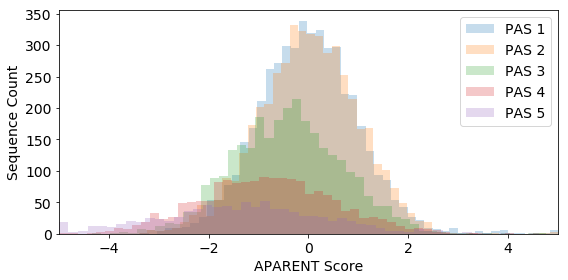

In [11]:
#Plot distribution of APARENT scores per PAS

f = plt.figure(figsize=(8, 4))

plt.hist(a[:, 0][m[:, 0] >= 1.], bins=50, alpha=0.25, label="PAS 1")
plt.hist(a[:, 1][m[:, 1] >= 1.], bins=50, alpha=0.25, label="PAS 2")
plt.hist(a[:, 2][m[:, 2] >= 1.], bins=50, alpha=0.25, label="PAS 3")
plt.hist(a[:, 3][m[:, 3] >= 1.], bins=50, alpha=0.25, label="PAS 4")
plt.hist(a[:, 4][m[:, 4] >= 1.], bins=50, alpha=0.25, label="PAS 5")

plt.legend(fontsize=14)

plt.xlim(-5., 5.)
plt.ylim(0.)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("APARENT Score", fontsize=14)
plt.ylabel("Sequence Count", fontsize=14)

plt.tight_layout()

plt.show()


In [12]:
#Partition data into train, valid, test

n_valid = 500
n_test = 500

x_train = x[:-n_valid - n_test, ...]
m_train = m[:-n_valid - n_test, ...]
l_train = l[:-n_valid - n_test, ...]
c_train = c[:-n_valid - n_test, ...]
y_train = y[:-n_valid - n_test, ...]
s_train = s[:-n_valid - n_test, ...]
d_train = d[:-n_valid - n_test, ...]
a_train = a[:-n_valid - n_test, ...]

x_valid = x[-n_valid - n_test:-n_test, ...]
m_valid = m[-n_valid - n_test:-n_test, ...]
l_valid = l[-n_valid - n_test:-n_test, ...]
c_valid = c[-n_valid - n_test:-n_test, ...]
y_valid = y[-n_valid - n_test:-n_test, ...]
s_valid = s[-n_valid - n_test:-n_test, ...]
d_valid = d[-n_valid - n_test:-n_test, ...]
a_valid = a[-n_valid - n_test:-n_test, ...]

x_test = x[-n_test:, ...]
m_test = m[-n_test:, ...]
l_test = l[-n_test:, ...]
c_test = c[-n_test:, ...]
y_test = y[-n_test:, ...]
s_test = s[-n_test:, ...]
d_test = d[-n_test:, ...]
a_test = a[-n_test:, ...]

print("x_train.shape = " + str(x_train.shape))
print("x_valid.shape = " + str(x_valid.shape))
print("x_test.shape = " + str(x_test.shape))


x_train.shape = (3715, 10, 1, 205, 4)
x_valid.shape = (500, 10, 1, 205, 4)
x_test.shape = (500, 10, 1, 205, 4)


In [13]:
#PAS network definition

def load_pas_network(n_cell_types=1) :

    conv_1 = Conv2D(16, (1, 8), padding='valid', activation='linear', name='pasnet_conv2d_1')
    batchnorm_1 = BatchNormalization(axis=-1, name='pasnet_batchnorm_1')
    relu_1 = Activation('relu')

    conv_2 = Conv2D(16, (1, 8), padding='valid', activation='linear', name='pasnet_conv2d_2')
    batchnorm_2 = BatchNormalization(axis=-1, name='pasnet_batchnorm_2')
    relu_2 = Activation('relu')

    #max_pool_3 = Lambda(lambda x: K.concatenate([K.mean(x, axis=(1, 2)), K.sum(x, axis=(1, 2)), K.max(x, axis=(1, 2))], axis=-1))
    max_pool_3 = Lambda(lambda x: K.mean(x, axis=(1, 2)))

    final_dense = Dense(n_cell_types, activation='linear', kernel_initializer='zeros', bias_initializer='zeros', name='pasnet_dense_2')

    def _net_func(sequence_input) :
        
        relu_1_out = relu_1(batchnorm_1(conv_1(sequence_input), training=True))
        relu_2_out = relu_2(batchnorm_2(conv_2(relu_1_out), training=True))

        max_pool_3_out = max_pool_3(relu_2_out)

        final_dense_out = final_dense(max_pool_3_out)
        
        return final_dense_out

    return _net_func


In [14]:
#Define model code

def get_kl_divergence(max_n_pas, n_cell_types) :

    def _kl_divergence(y_true, y_pred, pas_mask, cell_type_mask, max_n_pas=max_n_pas, n_cell_types=n_cell_types) :

        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        y_true = K.clip(y_true, K.epsilon(), 1.0 - K.epsilon())

        kl = y_true * K.log(y_true / y_pred)
        kl = kl * K.tile(K.expand_dims(cell_type_mask, axis=-1), (1, 1, max_n_pas))
        kl = kl * K.tile(K.expand_dims(pas_mask, axis=1), (1, n_cell_types, 1))
        total_kl = K.sum(kl, axis=-1)

        #mean_total_kl = K.sum(total_kl, axis=-1) / K.sum(cell_type_mask, axis=-1)
        mean_total_kl = K.mean(total_kl, axis=-1)

        return mean_total_kl

    return _kl_divergence

def get_difference_mse(max_n_pas, n_cell_types) :

    def _difference_mse(y_true, y_pred, pas_mask, cell_type_mask, diff_mask, max_n_pas=max_n_pas, n_cell_types=n_cell_types) :

        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        y_true = K.clip(y_true, K.epsilon(), 1.0 - K.epsilon())

        y_true_1 = K.expand_dims(y_true, axis=1)
        y_true_2 = K.expand_dims(y_true, axis=2)
        y_true_diff = y_true_1 - y_true_2

        y_pred_1 = K.expand_dims(y_pred, axis=1)
        y_pred_2 = K.expand_dims(y_pred, axis=2)
        y_pred_diff = y_pred_1 - y_pred_2

        cell_type_mask_1 = K.tile(K.expand_dims(K.expand_dims(cell_type_mask, axis=1), axis=-1), (1, 1, 1, max_n_pas))
        cell_type_mask_2 = K.tile(K.expand_dims(K.expand_dims(cell_type_mask, axis=2), axis=-1), (1, 1, 1, max_n_pas))
        cell_type_mask_diff = cell_type_mask_1 * cell_type_mask_2

        pas_mask_diff = K.tile(K.expand_dims(K.expand_dims(pas_mask, axis=1), axis=1), (1, n_cell_types, n_cell_types, 1))

        diff_mask_diff = cell_type_mask_2 = K.tile(K.expand_dims(diff_mask, axis=-1), (1, 1, 1, max_n_pas))

        net_mask_diff = pas_mask_diff * cell_type_mask_diff * diff_mask_diff

        margin_error = K.maximum(K.sign(y_true_diff) * (y_true_diff - y_pred_diff), 0.)
        se = K.switch(K.abs(y_true_diff) * net_mask_diff > 0.2, margin_error, K.zeros_like(y_true_diff))

        #se = K.abs(y_true_diff - y_pred_diff) * net_mask_diff

        #mse = K.switch(K.sum(net_mask_diff, axis=(1, 2, 3)) > 0., K.sum(se, axis=(1, 2, 3)) / K.sum(net_mask_diff, axis=(1, 2, 3)), K.zeros((K.shape(y_true)[0])))
        mse = K.mean(se, axis=(1, 2, 3))

        return mse

    return _difference_mse

def get_weighted_loss(loss_coeff=1.) :

    def _min_pred(y_true, y_pred) :
        return loss_coeff * y_pred

    return _min_pred

def initialize_model() :
    
    #Initialize PAS feature extractor network
    
    n_cell_types = y.shape[-2]

    #Load PAS network
    pas_net = load_pas_network(
        n_cell_types=n_cell_types
    )
    
    #Build predictor model
    #max_n_pas = 16

    pas_sequence = Input(shape=(max_n_pas, 1, 205, 4), name='pas_sequence')
    pas_mask = Input(shape=(max_n_pas,), name='pas_mask')
    pas_length = Input(shape=(max_n_pas,), name='pas_length')
    aparent_score = Input(shape=(max_n_pas,), name='aparent_score')

    #Initialize and execute Lambda split layers
    pas_sequences = []
    for i in range(max_n_pas) :
        split_pas_sequence = Lambda(lambda x, pas_ix=i: x[:, pas_ix, ...], name="split_pas_sequence_" + str(i))
        pas_sequences.append(split_pas_sequence(pas_sequence))

    #Execute PAS feature extractor on sequences
    pas_scores_per_pas = []
    for i in range(max_n_pas) :
        pas_score = pas_net(pas_sequences[i])
        expand_pas_score = Lambda(lambda x: K.expand_dims(x, axis=-1), name="expand_pas_score_" + str(i))
        pas_scores_per_pas.append(expand_pas_score(pas_score))

    concat_pas_scores = Lambda(lambda x: K.permute_dimensions(K.concatenate(x, axis=-1), (0, 2, 1)), name='concat_pas_scores')

    pas_score = concat_pas_scores(pas_scores_per_pas)

    pas_features_per_cell_type = []
    for i in range(n_cell_types) :
        make_pas_feature = Lambda(lambda x, pas_ix=i: K.concatenate([K.expand_dims(x[0][..., pas_ix], axis=-1) + K.expand_dims(x[2], axis=-1), K.expand_dims(x[1], axis=-1)], axis=-1), name="make_pas_feature_" + str(i))
        pas_features_per_cell_type.append(make_pas_feature([pas_score, pas_length, aparent_score]))

    rnn = LocallyConnected1D(1, (1,), activation='linear', name='apa_rnn_layer')

    apa_scores_per_cell_type = []
    for i in range(n_cell_types) :
        apa_scores = rnn(pas_features_per_cell_type[i])

        expand_apa_score = Lambda(lambda x: K.permute_dimensions(x, (0, 2, 1)), name='expand_apa_score_' + str(i))
        apa_scores_per_cell_type.append(expand_apa_score(apa_scores))

    concat_apa_scores = Lambda(lambda x: K.concatenate(x, axis=1), name='concat_apa_scores')
    apa_score = concat_apa_scores(apa_scores_per_cell_type)

    #Define masked softmax function
    def _masked_softmax(y, m, axis=-1) :

        exp_y = m * (K.exp(y) + K.epsilon())

        return exp_y / K.expand_dims(K.sum(exp_y, axis=axis), axis=axis)

    tile_mask = Lambda(lambda x, n_cell_types=n_cell_types: K.tile(K.expand_dims(x, axis=1), (1, n_cell_types, 1)), name="tile_mask")

    tiled_pas_mask = tile_mask(pas_mask)

    masked_softmax = Lambda(lambda x: _masked_softmax(x[0], x[1], axis=-1), name="masked_softmax")

    apa_prob = masked_softmax([apa_score, tiled_pas_mask])

    #Build PAS model
    pas_model = Model([pas_sequence], [pas_score])
    pas_model.get_layer("pasnet_dense_2").trainable = False

    pas_model.compile(
        optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
        loss='mean_squared_error'
    )

    #Build APA model
    apa_model = Model([pas_sequence, pas_mask, pas_length, aparent_score], [apa_score, apa_prob])

    apa_model.compile(
        optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
        loss='mean_squared_error'
    )

    #Define loss model
    apa_target = Input(shape=(n_cell_types, max_n_pas), name='apa_target')
    apa_support = Input(shape=(n_cell_types,), name='apa_support')
    apa_diff_mask = Input(shape=(n_cell_types, n_cell_types,), name='apa_diff_mask')

    #NLL cost
    nll_loss_func = get_kl_divergence(max_n_pas, n_cell_types)

    #Difference MSE cost
    diff_loss_func = get_difference_mse(max_n_pas, n_cell_types)

    #Execute NLL cost
    nll_loss = Lambda(lambda x: nll_loss_func(x[0], x[1], x[2], x[3]), name='nll')([
        apa_target,
        apa_prob,
        pas_mask,
        apa_support
    ])

    #Execute Difference MSE cost
    diff_loss = Lambda(lambda x: diff_loss_func(x[0], x[1], x[2], x[3], x[4]), name='difference')([
        apa_target,
        apa_prob,
        pas_mask,
        apa_support,
        apa_diff_mask
    ])

    loss_model = Model(
        [pas_sequence, pas_mask, pas_length, aparent_score, apa_target, apa_support, apa_diff_mask],
        [nll_loss, diff_loss]
    )

    loss_model.compile(
        optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
        loss={
            'nll' : get_weighted_loss(loss_coeff=1.0),
            'difference' : get_weighted_loss(loss_coeff=0.),
        }
    )
    
    return pas_model, apa_model, loss_model


In [69]:
#Train n bootstrap models

n_bootstraps = 10

use_bootstrap = False

dummy_train = np.zeros((x_train.shape[0], 1))
dummy_valid = np.zeros((x_valid.shape[0], 1))

train_histories = []

model_name = "human_convnet_16_16_no_dense_linear_leslie_hek293_brain_all_cuts"

for bootstrap_ix in range(n_bootstraps) :
    
    #Clear keras session
    K.clear_session()
    
    #Copy data
    x_train_curr = np.copy(x_train)
    m_train_curr = np.copy(m_train)
    l_train_curr = np.copy(l_train)
    c_train_curr = np.copy(c_train)
    y_train_curr = np.copy(y_train)
    s_train_curr = np.copy(s_train)
    d_train_curr = np.copy(d_train)
    a_train_curr = np.copy(a_train)

    x_valid_curr = np.copy(x_valid)
    m_valid_curr = np.copy(m_valid)
    l_valid_curr = np.copy(l_valid)
    c_valid_curr = np.copy(c_valid)
    y_valid_curr = np.copy(y_valid)
    s_valid_curr = np.copy(s_valid)
    d_valid_curr = np.copy(d_valid)
    a_valid_curr = np.copy(a_valid)
    
    if use_bootstrap :
        
        bootstrap_train_index = np.random.choice(np.arange(x_train_curr.shape[0]), size=x_train_curr.shape[0], replace=True)
        bootstrap_valid_index = np.random.choice(np.arange(x_valid_curr.shape[0]), size=x_valid_curr.shape[0], replace=True)
        
        x_train_curr = x_train_curr[bootstrap_train_index, ...]
        m_train_curr = m_train_curr[bootstrap_train_index, ...]
        l_train_curr = l_train_curr[bootstrap_train_index, ...]
        c_train_curr = c_train_curr[bootstrap_train_index, ...]
        y_train_curr = y_train_curr[bootstrap_train_index, ...]
        s_train_curr = s_train_curr[bootstrap_train_index, ...]
        d_train_curr = d_train_curr[bootstrap_train_index, ...]
        a_train_curr = a_train_curr[bootstrap_train_index, ...]

        x_valid_curr = x_valid_curr[bootstrap_valid_index, ...]
        m_valid_curr = m_valid_curr[bootstrap_valid_index, ...]
        l_valid_curr = l_valid_curr[bootstrap_valid_index, ...]
        c_valid_curr = c_valid_curr[bootstrap_valid_index, ...]
        y_valid_curr = y_valid_curr[bootstrap_valid_index, ...]
        s_valid_curr = s_valid_curr[bootstrap_valid_index, ...]
        d_valid_curr = d_valid_curr[bootstrap_valid_index, ...]
        a_valid_curr = a_valid_curr[bootstrap_valid_index, ...]
    
    print("Training model " + str(bootstrap_ix) + "...")
    
    pas_model, apa_model, loss_model = initialize_model()
    
    #Execute training procedure

    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)

    #1: Train model to fit APARENT score parameters
    _ = loss_model.fit(
        [x_train_curr, m_train_curr, l_train_curr, a_train_curr, y_train_curr, s_train_curr, d_train_curr],
        [dummy_train, dummy_train],
        shuffle=True,
        epochs=25,
        batch_size=32,
        validation_data=(
            [x_valid_curr, m_valid_curr, l_valid_curr, a_valid_curr, y_valid_curr, s_valid_curr, d_valid_curr],
            [dummy_valid, dummy_valid]
        ),
        callbacks=[early_stop],
        verbose = 0
    )
    
    #Re-compile PAS model with trainable feature detector
    pas_model.get_layer("pasnet_dense_2").trainable = True
    pas_model.compile(
        optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
        loss='mean_squared_error'
    )

    apa_model.compile(
        optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
        loss='mean_squared_error'
    )

    loss_model.compile(
        optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
        loss={
            'nll' : get_weighted_loss(loss_coeff=0.0),
            'difference' : get_weighted_loss(loss_coeff=100.),
        }
    )

    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)

    #2: Train tissue-specific APA model
    train_history = loss_model.fit(
        [x_train_curr, m_train_curr, l_train_curr, a_train_curr, y_train_curr, s_train_curr, d_train_curr],
        [dummy_train, dummy_train],
        shuffle=True,
        epochs=25,
        batch_size=32,
        validation_data=(
            [x_valid_curr, m_valid_curr, l_valid_curr, a_valid_curr, y_valid_curr, s_valid_curr, d_valid_curr],
            [dummy_valid, dummy_valid]
        ),
        callbacks=[early_stop],
        verbose = 0
    )
    
    train_histories.append(train_history)
    
    #Save model(s)
    save_dir = 'saved_models'

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

    model_path = os.path.join(save_dir, model_name + '_ensemble_' + str(bootstrap_ix) + '_pas_model' + '.h5')

    pas_model.save(model_path)
    print('Saved pas model at %s ' % (model_path))

    model_path = os.path.join(save_dir, model_name + '_ensemble_' + str(bootstrap_ix) + '_apa_model' + '.h5')

    apa_model.save(model_path)
    print('Saved apa model at %s ' % (model_path))


Training model 0...
Restoring model weights from the end of the best epoch
Epoch 00015: early stopping
Saved pas model at saved_models/human_convnet_16_16_no_dense_linear_leslie_hek293_brain_all_cuts_ensemble_0_pas_model.h5 
Saved apa model at saved_models/human_convnet_16_16_no_dense_linear_leslie_hek293_brain_all_cuts_ensemble_0_apa_model.h5 
Training model 1...
Restoring model weights from the end of the best epoch
Epoch 00014: early stopping
Saved pas model at saved_models/human_convnet_16_16_no_dense_linear_leslie_hek293_brain_all_cuts_ensemble_1_pas_model.h5 
Saved apa model at saved_models/human_convnet_16_16_no_dense_linear_leslie_hek293_brain_all_cuts_ensemble_1_apa_model.h5 
Training model 2...
Restoring model weights from the end of the best epoch
Epoch 00015: early stopping
Saved pas model at saved_models/human_convnet_16_16_no_dense_linear_leslie_hek293_brain_all_cuts_ensemble_2_pas_model.h5 
Saved apa model at saved_models/human_convnet_16_16_no_dense_linear_leslie_hek293

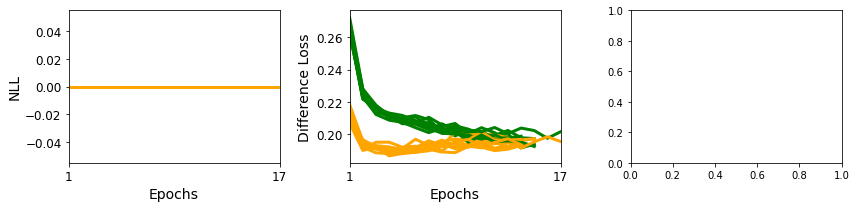

In [70]:
#Plot bootstrap training and validation losses

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3 * 4, 3))

max_n_epochs_actual = 0

for bootstrap_ix in range(n_bootstraps) :
    
    train_history = train_histories[bootstrap_ix]

    n_epochs_actual = len(train_history.history['nll_loss'])
    max_n_epochs_actual = max(max_n_epochs_actual, n_epochs_actual)
    
    ax1.plot(np.arange(1, n_epochs_actual + 1), train_history.history['nll_loss'], linewidth=3, color='green')
    ax1.plot(np.arange(1, n_epochs_actual + 1), train_history.history['val_nll_loss'], linewidth=3, color='orange')

    ax2.plot(np.arange(1, n_epochs_actual + 1), train_history.history['difference_loss'], linewidth=3, color='green')
    ax2.plot(np.arange(1, n_epochs_actual + 1), train_history.history['val_difference_loss'], linewidth=3, color='orange')

plt.sca(ax1)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("NLL", fontsize=14)
plt.xlim(1, max_n_epochs_actual)
plt.xticks([1, max_n_epochs_actual], [1, max_n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

plt.sca(ax2)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Difference Loss", fontsize=14)
plt.xlim(1, max_n_epochs_actual)
plt.xticks([1, max_n_epochs_actual], [1, max_n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

plt.show()


In [16]:
#Specify cell type labels

print(cell_types)

cell_type_dict = {
    cell_type : cell_type_i for cell_type_i, cell_type in enumerate(cell_types)
}


['leslie_count_hek293' 'leslie_count_brain']


In [15]:
#Evaluate boostrap ensemble on test data

n_bootstraps = 10

y_pred_scores = []
y_pred_probs = []

y_pred_scores_test = []
y_pred_probs_test = []

for bootstrap_ix in range(n_bootstraps) :
    
    #Clear keras session
    K.clear_session()
    
    print("Predicting using model " + str(bootstrap_ix) + "...")
    
    pas_model, apa_model, _ = initialize_model()
    
    #Load model(s)
    model_name = "human_convnet_16_16_no_dense_linear_leslie_hek293_brain_all_cuts"

    save_dir = 'saved_models'

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

    model_path = os.path.join(save_dir, model_name + '_ensemble_' + str(bootstrap_ix) + '_pas_model' + '.h5')
    #pas_model = load_model(model_path)
    pas_model.load_weights(model_path)

    def _masked_softmax(y, m, axis=-1) :

        exp_y = m * (K.exp(y) + K.epsilon())

        return exp_y / K.expand_dims(K.sum(exp_y, axis=axis), axis=axis)

    model_path = os.path.join(save_dir, model_name + '_ensemble_' + str(bootstrap_ix) + '_apa_model' + '.h5')
    #apa_model = load_model(model_path, custom_objects={
    #    '_masked_softmax' : _masked_softmax
    #})
    apa_model.load_weights(model_path)

    #Make predictions on all data
    y_pred_score, y_pred_prob = apa_model.predict(x=[x, m, l, a], batch_size=64, verbose=True)
    
    #Make predictions on test data
    y_pred_score_test, y_pred_prob_test = apa_model.predict(x=[x_test, m_test, l_test, a_test], batch_size=64, verbose=True)

    y_pred_scores.append(y_pred_score[None, ...])
    y_pred_probs.append(y_pred_prob[None, ...])

    y_pred_scores_test.append(y_pred_score_test[None, ...])
    y_pred_probs_test.append(y_pred_prob_test[None, ...])

y_pred_score = np.mean(np.concatenate(y_pred_scores, axis=0), axis=0)
y_pred_prob = np.mean(np.concatenate(y_pred_probs, axis=0), axis=0)

y_pred_score_test = np.mean(np.concatenate(y_pred_scores_test, axis=0), axis=0)
y_pred_prob_test = np.mean(np.concatenate(y_pred_probs_test, axis=0), axis=0)


Predicting using model 0...
500/500 [==============================] - 0s 354us/step
Predicting using model 1...
500/500 [==============================] - 0s 350us/step
Predicting using model 2...
500/500 [==============================] - 0s 349us/step
Predicting using model 3...
500/500 [==============================] - 0s 351us/step
Predicting using model 4...
500/500 [==============================] - 0s 351us/step
Predicting using model 5...
500/500 [==============================] - 0s 350us/step
Predicting using model 6...
500/500 [==============================] - 0s 350us/step
Predicting using model 7...
500/500 [==============================] - 0s 351us/step
Predicting using model 8...
500/500 [==============================] - 0s 351us/step
Predicting using model 9...
500/500 [==============================] - 0s 348us/step


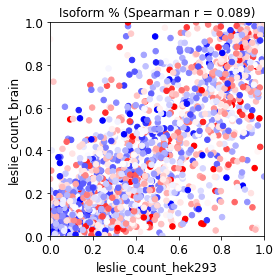

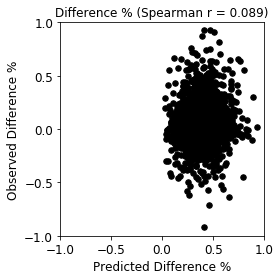

In [16]:
#Differential usage analysis

cell_type_1 = cell_types[0]
cell_type_2 = cell_types[1]

count_filter = 10.

cell_type_1_ix = cell_type_dict[cell_type_1]
cell_type_2_ix = cell_type_dict[cell_type_2]

c_total_1 = np.sum(c[:, cell_type_1_ix, :], axis=-1)
c_total_2 = np.sum(c[:, cell_type_2_ix, :], axis=-1)

y_kept = y[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]
y_pred_score_kept = y_pred_score[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]
y_pred_prob_kept = y_pred_prob[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]

s_kept = s[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]
m_kept = m[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]


y_1 = y_kept[:, cell_type_1_ix, :]
y_2 = y_kept[:, cell_type_2_ix, :]

y_pred_1 = y_pred_prob_kept[:, cell_type_1_ix, :]
y_pred_2 = y_pred_prob_kept[:, cell_type_2_ix, :]


#Test one PAS only

pas_ix = 0

min_y_diff = 0.0

m_flat = m_kept[:, pas_ix]

y_1_flat = y_1[:, pas_ix]
y_2_flat = y_2[:, pas_ix]

y_pred_1_flat = y_pred_1[:, pas_ix]
y_pred_2_flat = y_pred_2[:, pas_ix]

y_1_flat = y_1_flat[m_flat >= 1.]
y_2_flat = y_2_flat[m_flat >= 1.]

y_pred_1_flat = y_pred_1_flat[m_flat >= 1.]
y_pred_2_flat = y_pred_2_flat[m_flat >= 1.]

y_diff = y_1_flat - y_2_flat
y_pred_diff = y_pred_1_flat - y_pred_2_flat

#Re-filter on significant difference
y_1_flat = y_1_flat[np.abs(y_diff) > min_y_diff]
y_2_flat = y_2_flat[np.abs(y_diff) > min_y_diff]

y_pred_1_flat = y_pred_1_flat[np.abs(y_diff) > min_y_diff]
y_pred_2_flat = y_pred_2_flat[np.abs(y_diff) > min_y_diff]

y_pred_diff = y_pred_diff[np.abs(y_diff) > min_y_diff]
y_diff = y_diff[np.abs(y_diff) > min_y_diff]

r_val = spearmanr(y_diff, y_pred_diff)[0]

f = plt.figure(figsize=(4, 4))

vmin = np.quantile(y_pred_diff, q=0.02)
vmax = np.quantile(y_pred_diff, q=0.98)

plt.scatter(y_1_flat, y_2_flat, s=30, c=y_pred_diff, cmap='bwr', vmin=vmin, vmax=vmax)#, alpha=0.25

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)

plt.xlabel(cell_type_1, fontsize=12)
plt.ylabel(cell_type_2, fontsize=12)

plt.title("Isoform % (Spearman r = " + str(round(r_val, 3)) + ")", fontsize=12)

plt.tight_layout()

plt.savefig(model_name + '_ensemble_' + 'color_all.eps')
plt.savefig(model_name + '_ensemble_' + 'color_all.png', dpi=300)

plt.show()

f = plt.figure(figsize=(4, 4))

plt.scatter(y_pred_diff, y_diff, s=30, c='black')#, alpha=0.25

plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.xticks([-1, -0.5, 0., 0.5, 1], fontsize=12)
plt.yticks([-1, -0.5, 0., 0.5, 1], fontsize=12)

plt.xlabel("Predicted Difference %", fontsize=12)
plt.ylabel("Observed Difference %", fontsize=12)

plt.title("Difference % (Spearman r = " + str(round(r_val, 3)) + ")", fontsize=12)

plt.tight_layout()

plt.savefig(model_name + '_ensemble_' + 'scatter_all.eps')
plt.savefig(model_name + '_ensemble_' + 'scatter_all.png', dpi=300)

plt.show()


PAS 0:
- P-value = 0.3868821205598454
- n = 258


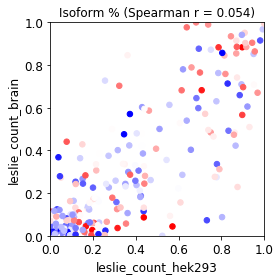

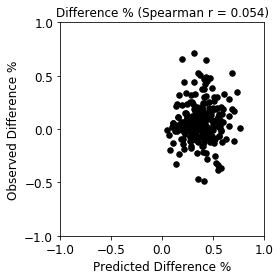

PAS -1:
- P-value = 4.529752091200156e-05
- n = 235


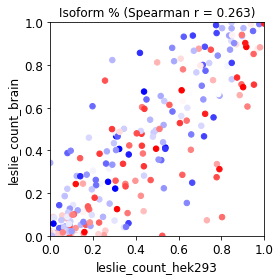

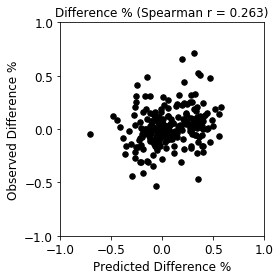

In [25]:
#Differential usage analysis (test set)

cell_type_1 = cell_types[0]
cell_type_2 = cell_types[1]

count_filter = 10.

cell_type_1_ix = cell_type_dict[cell_type_1]
cell_type_2_ix = cell_type_dict[cell_type_2]

c_total_1 = np.sum(c_test[:, cell_type_1_ix, :], axis=-1)
c_total_2 = np.sum(c_test[:, cell_type_2_ix, :], axis=-1)

y_kept = y_test[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]
y_pred_score_kept = y_pred_score_test[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]
y_pred_prob_kept = y_pred_prob_test[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]

s_kept = s_test[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]
m_kept = m_test[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]

y_1 = y_kept[:, cell_type_1_ix, :]
y_2 = y_kept[:, cell_type_2_ix, :]

y_pred_1 = y_pred_prob_kept[:, cell_type_1_ix, :]
y_pred_2 = y_pred_prob_kept[:, cell_type_2_ix, :]

#Test one PAS only

min_y_diff = 0.0

for pas_ix in [0, -1] :
    
    print("PAS " + str(pas_ix) + ":")

    m_flat = m_kept[:, pas_ix]

    y_1_flat = y_1[:, pas_ix]
    y_2_flat = y_2[:, pas_ix]

    y_pred_1_flat = y_pred_1[:, pas_ix]
    y_pred_2_flat = y_pred_2[:, pas_ix]

    if pas_ix == -1 :
        m_flat = m_kept[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) - 2]

        y_1_flat = y_1[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) - 2]
        y_2_flat = y_2[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) - 2]

        y_pred_1_flat = y_pred_1[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) - 2]
        y_pred_2_flat = y_pred_2[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) - 2]

    y_1_flat = y_1_flat[m_flat >= 1.]
    y_2_flat = y_2_flat[m_flat >= 1.]

    y_pred_1_flat = y_pred_1_flat[m_flat >= 1.]
    y_pred_2_flat = y_pred_2_flat[m_flat >= 1.]

    y_diff = y_1_flat - y_2_flat
    y_pred_diff = y_pred_1_flat - y_pred_2_flat

    #Re-filter on significant difference
    y_1_flat = y_1_flat[np.abs(y_diff) > min_y_diff]
    y_2_flat = y_2_flat[np.abs(y_diff) > min_y_diff]

    y_pred_1_flat = y_pred_1_flat[np.abs(y_diff) > min_y_diff]
    y_pred_2_flat = y_pred_2_flat[np.abs(y_diff) > min_y_diff]

    y_pred_diff = y_pred_diff[np.abs(y_diff) > min_y_diff]
    y_diff = y_diff[np.abs(y_diff) > min_y_diff]

    r_val, p_val = spearmanr(y_diff, y_pred_diff)

    print("- P-value = " + str(p_val))
    print("- n = " + str(y_diff.shape[0]))

    f = plt.figure(figsize=(4, 4))

    vmin = np.quantile(y_pred_diff, q=0.02)
    vmax = np.quantile(y_pred_diff, q=0.98)

    plt.scatter(y_1_flat, y_2_flat, s=30, c=y_pred_diff, cmap='bwr', vmin=vmin, vmax=vmax)

    plt.xlim(0, 1)
    plt.ylim(0, 1)

    plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)
    plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)

    plt.xlabel(cell_type_1, fontsize=12)
    plt.ylabel(cell_type_2, fontsize=12)

    plt.title("Isoform % (Spearman r = " + str(round(r_val, 3)) + ")", fontsize=12)

    plt.tight_layout()

    plt.savefig(model_name + '_ensemble_pas_' + str(pas_ix) + 'color_test.eps')
    plt.savefig(model_name + '_ensemble_pas_' + str(pas_ix) + 'color_test.png', dpi=300)

    plt.show()

    f = plt.figure(figsize=(4, 4))

    plt.scatter(y_pred_diff, y_diff, s=30, c='black')#, alpha=0.25

    plt.xlim(-1, 1)
    plt.ylim(-1, 1)

    plt.xticks([-1, -0.5, 0., 0.5, 1], fontsize=12)
    plt.yticks([-1, -0.5, 0., 0.5, 1], fontsize=12)

    plt.xlabel("Predicted Difference %", fontsize=12)
    plt.ylabel("Observed Difference %", fontsize=12)

    plt.title("Difference % (Spearman r = " + str(round(r_val, 3)) + ")", fontsize=12)

    plt.tight_layout()

    plt.savefig(model_name + '_ensemble_pas_' + str(pas_ix) + 'scatter_test.eps')
    plt.savefig(model_name + '_ensemble_pas_' + str(pas_ix) + 'scatter_test.png', dpi=300)

    plt.show()
